In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from datetime import datetime
from selenium import webdriver
from selenium.webdriver.chrome.options import Options  


In [2]:
chrome_options = Options()  
chrome_options.add_argument("--headless")  
chrome_options.add_argument("--no-sandbox")

driver = webdriver.Chrome('chromedriver', options=chrome_options)

In [3]:
# url = 'https://bnonews.com/index.php/2020/02/the-latest-coronavirus-cases/'
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vR30F8lYP3jG7YOq8es0PBpJIE5yvRVZffOyaqC0GgMBN6yt0Q-NI8pxS7hd1F9dYXnowSC6zpZmW9D/pubhtml'
driver.get(url)
content = driver.page_source


### Extract date time

In [4]:
# soup =BeautifulSoup(content, 'lxml')

In [5]:
# data = soup.findAll(text=re.compile("Last update: .+"))
# data

In [6]:
# m = re.search("Last update: (\d+ \w+ 202\d) at (\d+:\d+ [apAP].*[mM])", data[0])
# data_date_time = ' '.join([m.group(1), m.group(2)])
# data_date_time = re.sub("[\.]","",data_date_time)
# data_date_time = datetime.strptime(data_date_time, '%d %B %Y %I:%M %p').strftime('%Y-%m-%d %H:%M')
# data_date_time
data_date_time = datetime.now().strftime('%Y-%m-%d %H:%M')
data_date_time

'2020-03-05 12:09'

### Dataframes

In [7]:

dfs = pd.read_html(content)

In [8]:
len(dfs)
dfs[0]

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,1,"Last update: March 5, 2020, at 7:08 a.m. ET","Last update: March 5, 2020, at 7:08 a.m. ET","Last update: March 5, 2020, at 7:08 a.m. ET","Last update: March 5, 2020, at 7:08 a.m. ET","Last update: March 5, 2020, at 7:08 a.m. ET","Last update: March 5, 2020, at 7:08 a.m. ET","Last update: March 5, 2020, at 7:08 a.m. ET"
1,2,CASES,DEATHS,DEATHS,RECOVERED,RECOVERED,NaN,NaN
2,3,96220,3309,3309,53305,53305,NaN,NaN
3,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,MAINLAND CHINA,Cases,Deaths,Serious,Critical,Recovered,NaN
...,...,...,...,...,...,...,...,...
97,98,Argentina,1,0,NaN,NaN,NaN,NaN
98,99,Liechtenstein,1,0,NaN,NaN,NaN,Source
99,100,Poland,1,0,0,0,0,Source
100,101,Slovenia,1,0,NaN,NaN,0,Source


### International

In [9]:
df_intl=dfs[0]
df_intl  = df_intl .drop(df_intl .columns[0], axis=1)
df_intl  = df_intl .drop(list(range(16)), axis=0)
df_intl.columns=['international', 'cases', 'd1', 'd2', 'd3', 'd4', 'd5']
df_intl



,international,cases,d1,d2,d3,d4,d5
16,South Korea,5766,42,27,25,88,Source
17,Iran,3513,107,-,-,552,Source
18,Italy,3089,107,297,-,276,Source
19,Diamond Princess,706,6,34,-,40,Source
20,Germany,349,0,-,2,16,Source
...,...,...,...,...,...,...,...
97,Argentina,1,0,NaN,NaN,NaN,NaN
98,Liechtenstein,1,0,NaN,NaN,NaN,Source
99,Poland,1,0,0,0,0,Source
100,Slovenia,1,0,NaN,NaN,0,Source


In [10]:
df_intl.columns = df_intl.columns.map(str.lower)


#### Cases

In [11]:
df_intl_cases = df_intl[['international', 'cases']].set_index('international').T
df_intl_cases = df_intl_cases.apply(lambda row: 
                   [re.sub('[^\d]+', '', x)  for x in row ])
df_intl_cases = df_intl_cases.apply(lambda row: 
                   [int(x) if x!='' else 0  for x in row ])

In [12]:
df_intl_cases = df_intl_cases.drop(['TOTAL'], axis=1)

In [13]:
# add date time column
df_intl_cases.insert(0, 'datetime', data_date_time)
df_intl_cases

international,datetime,South Korea,Iran,Italy,Diamond Princess,Germany,Japan,France,Spain,United States,...,Latvia,Tunisia,Jordan,Andorra,Armenia,Dominican Republic,Argentina,Liechtenstein,Poland,Slovenia
cases,2020-03-05 12:09,5766,3513,3089,706,349,331,285,248,159,...,1,1,1,1,1,1,1,1,1,1


#### Save to file

In [14]:
from pathlib import Path
csv_file = 'data/bnonews-international.csv'

df = df_intl_cases

if Path(csv_file).exists():
    old_df = pd.read_csv(csv_file, parse_dates=True)

    df = pd.concat([old_df, df], sort=True)
df = df.set_index('datetime').fillna(0)

In [15]:

df = df.loc[~df.index.duplicated(keep='first')]
df.sort_values(by=['datetime'], inplace=True)


for col in df.columns:
    df[col] = df[col].astype('int')
    
df

,Afghanistan,Algeria,Andorra,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahrain,Belarus,...,Sweden,Switzerland,Taiwan,Thailand,Tunisia,UAE,Ukraine,United Kingdom,United States,Vietnam
datetime,,,,,,,,,,,,,,,,,,,,,
2020-02-06 08:03,0,0,0,0,0,15,0,0,0,0,...,1,0,0,25,0,5,0,2,12,12
2020-02-06 08:19,0,0,0,0,0,15,0,0,0,0,...,1,0,0,25,0,5,0,3,12,12
2020-02-06 09:01,0,0,0,0,0,15,0,0,0,0,...,1,0,0,25,0,5,0,3,12,12
2020-02-06 09:46,0,0,0,0,0,15,0,0,0,0,...,1,0,0,25,0,5,0,3,12,12
2020-02-06 17:56,0,0,0,0,0,15,0,0,0,0,...,1,0,0,25,0,5,0,3,12,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-05 08:10,1,17,1,1,1,52,29,3,49,6,...,52,80,42,47,1,27,1,85,159,16
2020-03-05 09:10,1,17,1,1,1,52,37,3,49,6,...,52,80,42,47,1,27,1,88,159,16
2020-03-05 10:09,1,17,1,1,1,52,37,3,49,6,...,52,80,42,47,1,27,1,88,159,16


In [16]:

df.to_csv(csv_file, index=True)


Text(0.5, 0, 'Number of cases, sampled at 2020-03-05 12:09')

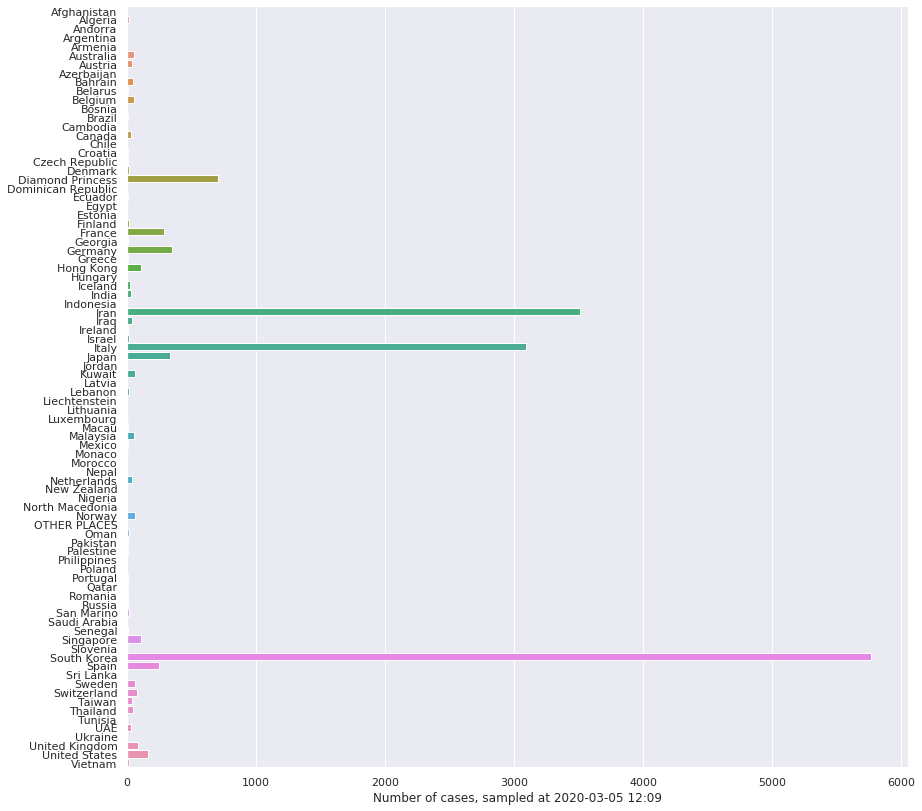

In [17]:
import seaborn as sns

series = df.iloc[-1]

sns.set(rc={'figure.figsize':(14,14)})
ax = sns.barplot(y=series.index, x=series)
ax.set_xlabel('Number of cases, sampled at '+series.name)



In [18]:
png_file='images/bnonews-international.png'
fig = ax.get_figure()
fig.savefig(png_file)